# Monitoring coastal erosion along Australia's coastline <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Acknowledgement**: This notebook was originally created by [Digital Earth Australia (DEA)](https://www.ga.gov.au/about/projects/geographic/digital-earth-australia) and has been modified for use in the EY Data Science Program

* **Products used:** 
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)



## Background

Over 40% of the world’s population lives within 100 km of the coastline. 
However, coastal environments are constantly changing, with erosion and coastal change presenting a major challenge to valuable coastal infrastructure and important ecological habitats. 
Up-to-date data on coastal change and erosion is essential for coastal managers to be able to identify and minimise the impacts of coastal change and erosion.

Monitoring coastlines and rivers using field surveys can be challenging and hazardous, particularly at regional or national scale. 
Aerial photography and LiDAR can be used to monitor coastal change, but this is often expensive and requires many repeated flights over the same areas of coastline to build up an accurate history of how the coastline has changed across time.

### Digital Earth Australia use case

Imagery from satellites such as the [NASA/USGS Landsat program](https://www.usgs.gov/land-resources/nli/landsat) is available for free for the entire planet, making satellite imagery a powerful and cost-effective tool for monitoring coastlines and rivers at regional or national scale. 
By identifying and extracting the precise boundary between water and land based on satellite data, it is possible to extract accurate shorelines that can be compared across time to reveal hotspots of erosion and coastal change.

The usefulness of satellite imagery in the coastal zone can be affected by the presence of clouds, sun-glint over water, poor water quality (e.g. sediment) and the influence of tides.
The effect of these factors can be reduced by combining individual noisy images into cleaner "summary" or composite layers, and filtering the data to focus only on images taken at certain tidal conditions (e.g. mid tide). 

Recently, Geoscience Australia combined 32 years of Landsat data from the Digital Earth Australia archive with tidal modelling to produce **Digital Earth Australia Coastlines**, a continental dataset providing annual shorelines and rates of change along the entire Australian coastline from 1988 to the present (for more information, explore the dataset on the [interactive DEA Maps platform](https://maps.dea.ga.gov.au/#share=s-DEACoastlines&playStory=1)).

## Description

In this example, we demonstrate a simplified version of the DEA Coastlines method that combines data from the Landsat 5, 7 and 8 satellites with image compositing and tide filtering techniques to accurately map shorelines across time and identify areas that have changed significantly between 1988 and 2018. 
This example demonstrates how to:

1.  Load cloud-free Landsat time series data
2.  Compute a water index (MNDWI)
3.  Filter images by tide height
4.  Create "summary" or composite images for given time periods
5.  Extract and visualise shorelines across time

***


## Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import datacube
import sys
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../scripts')
from dea_dask import create_local_dask_cluster
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs
from dea_bandindices import calculate_indices
from dea_spatialtools import subpixel_contours
from dea_plotting import display_map
from dea_plotting import rgb
from dea_plotting import map_shapefile

# Create local dask cluster to improve data load time
create_local_dask_cluster()


Client Scheduler: tcp://127.0.0.1:46793 Dashboard: /proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 13.79 GB


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app='Coastal_erosion')


### Analysis parameters

The following cell set important parameters for the analysis:

* `lat_range`: The latitude range to analyse (e.g. `(-38.64, -38.66)`). 
For reasonable load times, keep this to a range of ~0.1 degrees or less.
* `lon_range`: The longitude range to analyse (e.g. `(145.700, 145.745)`). 
For reasonable load times, keep this to a range of ~0.1 degrees or less.
* `time_range`: The date range to analyse (e.g. `('2000', '2020') `)
* `time_step`: This parameter allows us to choose the length of the time periods we want to compare: e.g. shorelines for each year, or shorelines for each six months etc. 
`1Y` will generate one coastline for every year in the dataset; `6M` will produce a coastline for every six months, etc.


**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example explores coastal change in the Bunurong Coastal Park, a coastal park located along the coast of Inverloch in the South Gippsland region of Victoria, Australia.



In [3]:
lat_range = (-38.64, -38.66)
lon_range = (145.700, 145.745)
time_range = ('2018', '2020')
time_step = '3M'


## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [4]:
display_map(x=lon_range, y=lat_range)


## Load cloud-masked Landsat data
The first step in this analysis is to load in Landsat data for the `lat_range`, `lon_range` and `time_range` we provided above. 
The code below first connects to the datacube database, and then uses the `load_ard` function to load in data from the Landsat 7 and 8 satellites for the area and time included in `lat_range`, `lon_range` and `time_range`. 
The function will also automatically mask out clouds from the dataset, allowing us to focus on pixels that contain useful data:

In [5]:
# Create the 'query' dictionary object, which contains the longitudes, 
# latitudes and time provided above
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_swir_1'],
    'resolution': (-30, 30),
}

# Identify the most common projection system in the input query 
# output_crs = mostcommon_crs(dc=dc, product='ga_ls7e_ard_3', query=query)
output_crs = "epsg:32656"

# Load available data from both Landsat satellites
landsat_ds = load_ard(dc=dc, 
                      products=[ 'ga_ls7e_ard_3', 
                                'ga_ls8c_ard_3'],                      
                      output_crs=output_crs,
                      align=(15, 15),
                      group_by='solar_day',
                      dask_chunks={},
                      **query)


Finding datasets
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Returning 54 time steps as a dask array


**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` argument revels the number of time steps in the data set, as well as the number of pixels in the `x` (longitude) and `y` (latitude) dimensions.

In [6]:
print(landsat_ds)

<xarray.Dataset>
Dimensions:       (time: 54, x: 138, y: 85)
Coordinates:
  * time          (time) datetime64[ns] 2018-01-09T00:03:57.376628 ... 2019-0...
  * y             (y) float64 -4.302e+06 -4.302e+06 ... -4.304e+06 -4.304e+06
  * x             (x) float64 -1.357e+05 -1.357e+05 ... -1.316e+05 -1.316e+05
    spatial_ref   int32 32656
Data variables:
    nbart_red     (time, y, x) float32 dask.array<chunksize=(1, 85, 138), meta=np.ndarray>
    nbart_green   (time, y, x) float32 dask.array<chunksize=(1, 85, 138), meta=np.ndarray>
    nbart_blue    (time, y, x) float32 dask.array<chunksize=(1, 85, 138), meta=np.ndarray>
    nbart_swir_1  (time, y, x) float32 dask.array<chunksize=(1, 85, 138), meta=np.ndarray>
Attributes:
    crs:           epsg:32656
    grid_mapping:  spatial_ref


### Plot example timestep in true colour
To visualise the data, use the pre-loaded `rgb` utility function to plot a true colour image for a given time-step. 
White areas indicate where clouds or other invalid pixels in the image have been masked.

Change the value for `timestep` and re-run the cell to plot a different timestep (timesteps are numbered from `0` to `n_time - 1` where `n_time` is the total number of timesteps; see the `time` listing under the `Dimensions` category in the dataset print-out above).


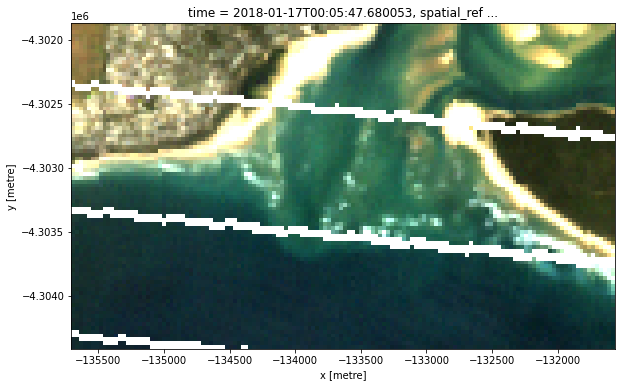

In [7]:
# Set the timesteps to visualise
timestep = 1

# Generate RGB plots at each timestep
rgb(landsat_ds, 
    index=timestep,
    percentile_stretch=(0.00, 0.95))


## Compute Modified Normalised Difference Water Index
To extract shoreline locations, we need to be able to seperate water from land in our study area. 
To do this, we can use our Landsat data to calculate a water index called the `Modified Normalised Difference Water Index`, or MNDWI. 
This index uses the ratio of green and mid-infrared radiation to identify the presence of water [(Xu 2006)](http://www.aari.ru/docs/pub/060804/xuh06.pdf). 
The formula is:

$$
\begin{aligned}
\text{MNDWI} &= \frac{(\text{Green} - \text{MIR})}{(\text{Green} + \text{MIR})}
\end{aligned}
$$

where `Green` is the green band and `MIR` is the mid-infrared band. 
For Landsat, we can use the Short-wave Infrared (SWIR) 1 band as our measure for `MIR`.

When it comes to interpreting the index, **High values (greater than 0, blue colours) typically represent water pixels**, while **low values (less than 0, red colours) represent land**. 
You can use the cell below to calculate and plot one of the images after calculating the index.

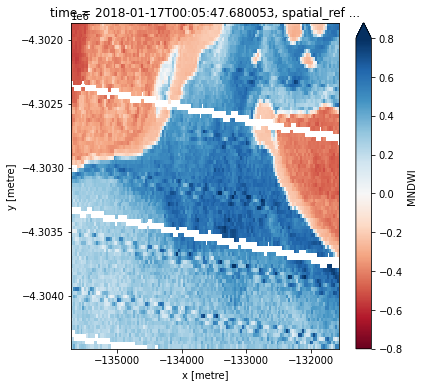

In [8]:
# Calculate the water index
landsat_ds = calculate_indices(landsat_ds, index='MNDWI', 
                               collection='ga_ls_3')

# Plot the resulting image for the same timestep selected above
landsat_ds.MNDWI.isel(time=timestep).plot(cmap='RdBu',
                                          size=6,
                                          aspect=1,
                                          vmin=-0.8,
                                          vmax=0.8)
plt.show()


How does the plot of the index compare to the optical image from earlier? Was there water or land anywhere you weren't expecting?

## Combine observations into noise-free summary images
Individual remote sensing images can be affected by noisy data, including clouds, sunglint and poor water quality conditions (e.g. sediment). To produce cleaner images that can be compared more easily across time, we can create 'summary' images or composites that combine multiple images into one image to reveal the median or 'typical' appearance of the landscape for a certain time period. In this case, we use the median as the summary statistic because it prevents strong outliers (like masked cloud values) from skewing the data, which would not be the case if we were to use the mean.

In the code below, we take the time series of images and combine them into single images for each `time_step`. For example, if `time_step = '2Y'`, the code will produce one new image for each two-year period in the dataset. This step can take **several minutes to load** if the study area is large.

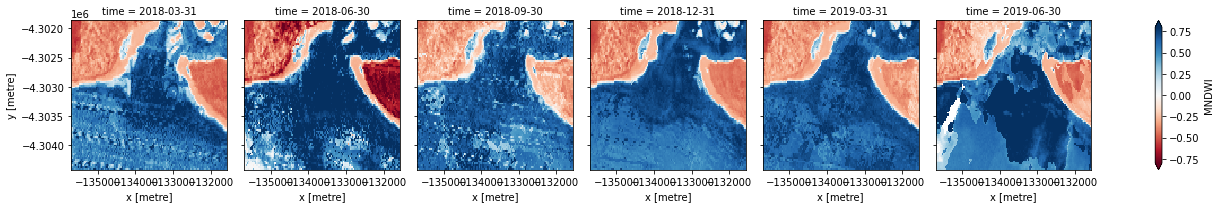

In [9]:
time_step = '3M'

# Combine into summary images by `time_step`
landsat_summaries = (landsat_ds.MNDWI
                     .compute()
                     .resample(time=time_step, closed='left')
                     .median('time'))

# Plot the output summary images
landsat_summaries.plot(col='time',
                       cmap='RdBu',
                       col_wrap=6,
                       vmin=-0.8,
                       vmax=0.8)
plt.show()


## Extract shorelines from imagery
We now want to extract an accurate shoreline for each each of the summary images above (e.g. 1987, 1989 etc. summaries). 
The code below identifies the boundary between land and water by tracing a line along pixels with a water index value of `0` (halfway between land and water water index values). 
It returns a `geopandas.GeoDataFrame` with one line feature for each time step:


Operating in single z-value, multiple arrays mode
Writing contours to ./outputs/Coastal_erosion/output_waterlines.geojson


/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


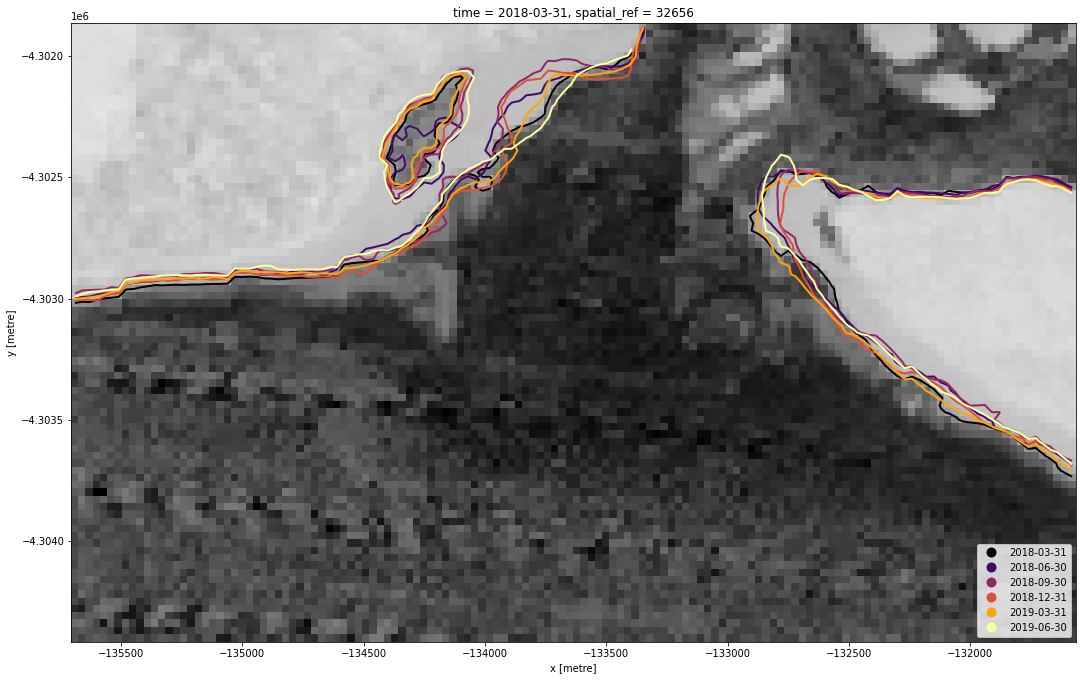

In [10]:
path = './outputs/Coastal_erosion/'

# Extract waterlines
contours_gdf = subpixel_contours(da=landsat_summaries,
                                 z_values=0,
                                 crs=landsat_ds.crs,
                                 affine=landsat_ds.geobox.transform,
                                 output_path=path + f'output_waterlines.geojson',
                                 min_vertices=50)

# Plot output shapefile over the first MNDWI layer in the time series
landsat_summaries.sel(time='2018-03-31').plot(size=12, 
                                    cmap='Greys', 
                                    add_colorbar=False)
contours_gdf.plot(ax=plt.gca(), 
                  column='time', 
                  cmap='inferno',
                  linewidth=2,
                  legend=True, 
                  legend_kwds={'loc': 'lower right'})
plt.show()


The above plot is a basic visualisation of the contours returned by the `subpixel_contours` function. 
Given we now have the shapefile, we can use a more complex function to make an interactive plot for viewing the change in shoreline over time below.

### Plot interactive map of output shorelines coloured by time
The next cell provides an interactive map with an overlay of the shorelines identified in the previous cell. 
Run it to view the map.

Zoom in to the map below to explore the resulting set of shorelines. 
Older shorelines are coloured in yellow, and more recent shorelines in red.
Hover over the lines to see the time period for each shoreline printed above the map.
Using this data, we can easily identify areas of coastline or rivers that have changed significantly over time, or areas that have remained stable over the entire time period. 


In [11]:
map_shapefile(gdf=contours_gdf, attribute='time', cmap='inferno', weight=2)


Label(value='')

Map(center=[-38.64779958654613, 145.72288688328598], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Drawing conclusions

Here are some questions to think about:

* What can you conclude about the change in the shoreline? 
* Which sections of the shoreline have seen the most change? 
* Is the change consistent with erosion? 
* What other information might you need to draw additional conclusions about the cause of the change?

***
## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please review the FAQ section and support options on the [EY Data Science platform](https://datascience.ey.com/).